In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

## Introduction: Error Correction using polynomials


Plain text: Script \
**Bold:** Comments 




For our main QR code data, we need a far more efficient scheme, one that doesn’t require lookup tables or doubling or tripling our data size.

The solution uses the Lagrange polynomial (though british mathematician Edward Warring first wrote it down in 1779, 16 years before Joseph-Louis Lagrange). The idea is:\
“Given any k points on a plane, there exists a single unique, (k-1)th degree polynomial that passes through all of them.”

Let’s say I want to send 4 numbers: (1,-2,3,5). When turned into coordinates on a graph, these lie along a 3rd degree polynomial.

**Plot a polynomial with co-ordinates [(0,1), (1, -2), (2,3), (3,5)]**


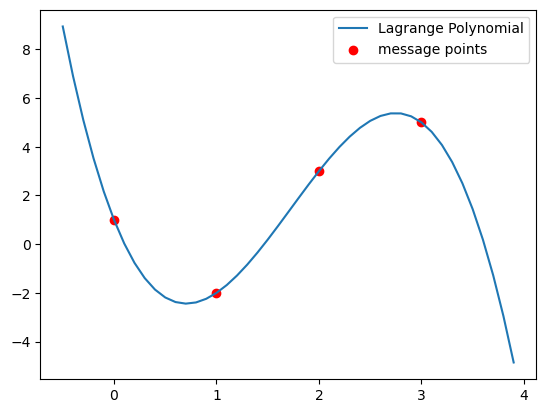

In [2]:
message = [1, -2, 3, 5]

x = np.arange(0,4,1)
y = np.array(message)

poly = lagrange(x, y)
x_new = np.arange(-0.5,4,0.1)
plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Lagrange Polynomial')
plt.scatter(x, y, c='red', label="message points")
plt.legend()
plt.show()

Now, if I can somehow send you this polynomial, and we both agree to evaluate it at the same points **[x = 0, 1, 2, 3]**, you can easily recover the message!


How to add redundancy? Easy – add two more points that lie along this same polynomial. 

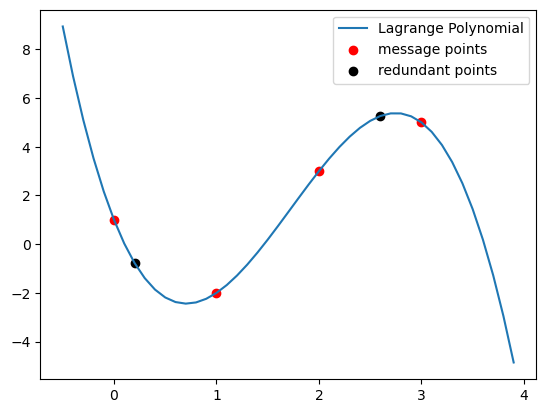

In [3]:
x1 = np.array([0.2, 2.6])
y1 = Polynomial(poly.coef[::-1])(x1)

plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Lagrange Polynomial')
plt.scatter(x, y, c='red', label="message points")
plt.scatter(x1, y1, c='k', label='redundant points')
plt.legend()
plt.show()

Now I can send you six numbers **[1,-2,3,5,a,b]** instead of four. Even if 2 numbers get erased, you can still use Lagrange interpolation over the remaining 4 to recover the Polynomial, and hence my message. 

And if two numbers have an error? We will know about it, because a degree-3 polynomial can no longer fit the six points. **[[They would lie along a degree-5  lagrange polynomial]]**


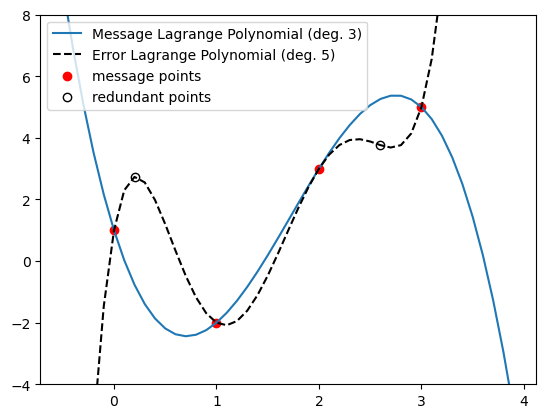

In [4]:
x2 = np.array([0.2, 2.6])
y2 = Polynomial(poly.coef[::-1])(x2)
y2[0] += 3.5
y2[1] -= 1.5

x_err = np.concatenate((x, x2), axis=0)
y_err = np.concatenate((y, y2), axis=0)
poly_err = lagrange(x_err, y_err)

plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Message Lagrange Polynomial (deg. 3)')
plt.plot(x_new, Polynomial(poly_err.coef[::-1])(x_new), color='k', linestyle='--', label='Error Lagrange Polynomial (deg. 5)')
plt.scatter(x, y, c='red', label="message points")
plt.scatter(x2, y2, ec='k', facecolor='w', label='redundant points')
plt.legend()
#plt.xlim(-0.5,3.2)
plt.ylim(-4,8)
plt.show()

In [5]:
# Coefficients of our message Lagrange polynomial:

Polynomial(poly.coef[::-1]).coef

array([  1.        , -10.66666667,   9.5       ,  -1.83333333])

But how can one send a polynomial? One way is to use coefficients. 

**onscreen: $$ p(x) = ax^3 + bx^2 + cx + d $$**

However, the polynomial passing through our 4 message points looks particularly clunky:

**onscreen: $$ p(x) = -1.833x^3 +9.5x^2 -10.66x +1 $$**

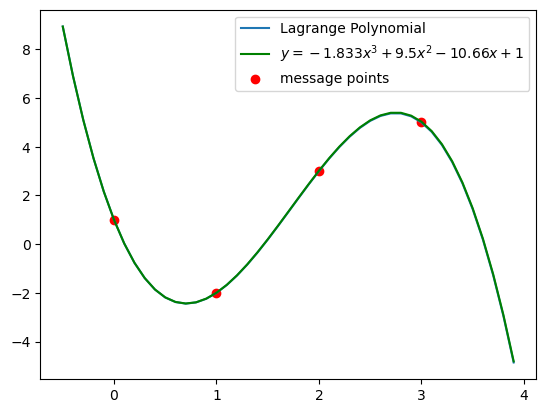

In [6]:
message = [1, -2, 3, 5]

x = np.arange(0,4,1)
y = np.array(message)

poly = lagrange(x, y)
x_new = np.arange(-0.5,4,0.1)
y_new = - 1.833*x_new**3 + 9.5*x_new**2 -10.66*x_new + 1

plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Lagrange Polynomial')
plt.plot(x_new, y_new, c='green', label=r'$y = -1.833x^3 + 9.5x^2 - 10.66x + 1$')
plt.scatter(x, y, c='red', label="message points")
plt.legend()
plt.show()

It would be way easier if I could write the polynomial using my message numbers instead:

**onscreen: $$ p(x) = 1x^3 -2x^2 +3x +5 $$**

Obviously, this is different from the Lagrange Polynomial:

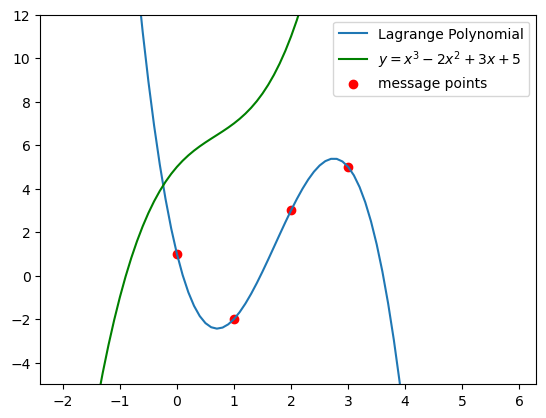

In [7]:
x = np.arange(0,4,1)
y = np.array(message)

poly = lagrange(x, y)
x_new = np.arange(-2,6,0.1)
y_new = x_new**3 -2*x_new**2 +3*x_new + 5

plt.plot(x_new, Polynomial(poly.coef[::-1])(x_new), label='Lagrange Polynomial')
plt.plot(x_new, y_new, c='green', label=r'$y = x^3 -2x^2 +3x + 5$')
plt.scatter(x, y, c='red', label="message points")
plt.ylim(-5,12)
plt.legend()
plt.show()

But there is still a clever way to use it!

Let's first add two redundant coefficients. This turns it into a 5th degree polynomial:

**onscreen: $$ p(x) \times x^2 = 1x^5 -2x^4 +3x^3 +5x^2$$** and adding in the coefficients $$ax + b$$

Now to find a and b, we do the following:

* Divide $p(x) \times x^2$ by a "generator polynomial" $g(x) = (x-1)(x-2) = x^2-3x+1$, that has its roots at two values $x=1$ and $x=2$ that both you and I know in advance.
* This division gives us a quotient and remainder polynomial, as: $$ p(x) \times x^2= q(x)g(x) + r(x); $$ $$q(x) = x^3 + x^2 + 4 x + 15;$$ $$r(x) = 37 x - 30$$
* Put the remainder polynomial on the left hand side, and we have our a and b! $$s(x) = x^2 p(x) - r(x) = 1x^5 - 2x^4 +3x^3 +5x^2 - 37x + 30$$

THIS, forms the message that I send you: **[1, -2, 3, 5, -37, 30]**

Now $s(x)$ is a 5th degree polynomial with our message and redundant pieces as coefficients. But watch what happens when we plot it:

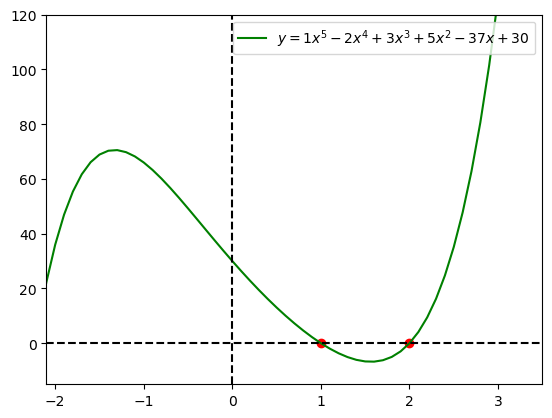

In [27]:
x = np.arange(-2.5,6,0.1)
y = x**5 - 2*x**4 + 3*x**3 + 5*x**2 - 37*x + 30

plt.plot(x, y, c='green', label=r'$y = 1x^5 - 2x^4 +3x^3 +5x^2 - 37x + 30$')
plt.axhline(y=0, c='k', linestyle='--')
plt.axvline(x=0, c='k', linestyle='--')
plt.scatter([1,2],[0,0],c='red')
plt.xlim(-2.1,3.5)
plt.ylim(-15,120)
plt.legend()
plt.show()

In [29]:
32 - 32 + 24 + 20 - 37*2 + 30

0

It is actually a 3rd degree polynomial hiding in disguise! 
This is because $$s(x) = q(x)*g(x) = (x^3 + x^2 + 4 x + 15)(x-1)(x-2)$$

It has two very convenient features:

1) The first coefficients always make up our original message followed by the redundant bits in order,
2) The polynomial ALWAYS equals $0$ at our predetermined points $x=(1,2)$

That is, _as long as there are no errors!_. If the message polynomial is NOT zero at any of the syndrome values, there’s an error in the code! 

The two values $x=1$ and $x=2$ are called “syndromes”

Which is an apt term, defined as “a group of signs that occur together and characterize a particular abnormality.” 

In [50]:
def eval_poly(message,x):
    a = float(message[0])
    b = float(message[1])
    c = float(message[2])
    d = float(message[3])
    e = float(message[4])
    f = float(message[5]) 
    print(a,b,c,d,e,f)
    return(a*x**5 + b*x**4 + c*x**3 + d*x**2 + e*x + f)


def check_error(message):
    ex1 = eval_poly(message,1)
    ex2 = eval_poly(message,2)
    print(f"s(x1) = {ex1}")
    print(f"s(x2) = {ex2}")
    if ex1 or ex2 != 0:
        print("transmitted message has an error")
    else:
        print("No errors in transmission!")
    return ex1, ex2


message = np.array([1,-2,3,5,-37,30])
check_error(message)

1.0 -2.0 3.0 5.0 -37.0 30.0
1.0 -2.0 3.0 5.0 -37.0 30.0
s(x1) = 0.0
s(x2) = 0.0
No errors in transmission!


(0.0, 0.0)

Let’s say we have an error position 4:

**onscreen: The message has changed from [1,-2,3,5,-37,30] to [1,-2,3,6,-37,30]** 

In [62]:
message = np.array([1,-2,3,6,-37,30])
check_error(message)

1.0 -2.0 3.0 6.0 -37.0 30.0
1.0 -2.0 3.0 6.0 -37.0 30.0
s(x1) = 1.0
s(x2) = 4.0
transmitted message has an error


(1.0, 4.0)

Now, $$s(x=1) = (1)^5 - 2(1)^4 +3(1)^3 + 6(1)^2 - 37(1) + 30 = 1,$$ and $$s(2) = (2)^5 - 2(2)^4 +3(2)^3 + 6(2)^2 - 37(2) + 30 = 4$$

The syndromes are not equal, which means there's an error!




In [80]:
def get_poly(message, syn):
    poly = message[0]*syn**5 + message[1]*syn**4 + message[2]*syn**3 + message[3]*syn**2 + message[4]*syn + message[5]
    return float(poly)

def error_correct(message):

    for pos in range(len(message)):
        msg_tmp = np.copy(message)
        msg_tmp[pos] = 0
        syn1 = -get_poly(msg_tmp, 1)
        syn2 = (-get_poly(msg_tmp, 2)/np.power(2, 5-pos))
        print(f"Syndromes if error at position {pos+1}: s1 = {syn1}, s2 = {syn2}")
    return

error_correct(np.array([1,-2,3,6,-37,30]))      
        



Syndromes if error at position 1: s1 = -0.0, s2 = 0.875
Syndromes if error at position 2: s1 = -3.0, s2 = -2.25
Syndromes if error at position 3: s1 = 2.0, s2 = 2.5
Syndromes if error at position 4: s1 = 5.0, s2 = 5.0
Syndromes if error at position 5: s1 = -38.0, s2 = -39.0
Syndromes if error at position 6: s1 = 29.0, s2 = 26.0


We can even go a step further and find out where the error was made, and correct it as well. Let’s assume the error was in the second coefficient **[1,e,3,5,-37,30]**. Since $s(x)$ is supposed to be 0 at the syndromes, we place a variable in the second coefficient and calculate its value if $s(1)=0$ & $s(2)=0$

$$ (1)^5 +e(1)^4 +3(1)^3 + 6(1)^2 - 37(1) + 30 = 0, $$ or $$e = -3$$

and 

$$ (2)^5 +e(2)^4 +3(2)^3 + 6(2)^2 - 37(2) + 30 = 0, $$ or $$e = -2.25$$

These are not equal -- a contradiction! We find the same for other positions, EXCEPT when we reach the place where the error has occured:

**onscreen: position 1, s1 = 0, s2 = 0.875 \
position 2, s1 = -3, s2 = -2.25 \
position 3, s1 = 2, s2 = 2.5 \
(highlight) position 4, s1 = 5, s2 = 5 \
position 5, s1 = -38, s2 = -39 \
position 6, s1 = 29, s2 = 26**


And when the syndromes are equal, their value is also the one in the corrected message! Our transmitted message should have a 5 in the fourth position.
